**Author**: JW Debelius<br>
**Email**: justine.debelius@ki.se<br>
**Date**: October 2020<br>
**Enviroment**: qiime2-2020.8 plus rescript and q2-sidle



In [1]:
import itertools as it
import os

import biom
from matplotlib import rcParams
import matplotlib.colors as mplc
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sn
import statsmodels.api as sms
import statsmodels.formula.api as smf
import skbio


from qiime2 import Artifact, Metadata, MetadataColumn
import qiime2.plugins.diversity.actions as q2_diversity
import qiime2.plugins.emperor.visualizers as q2_emperor

In [2]:
rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
rcParams['pdf.fonttype'] = 42
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [3]:
%matplotlib inline

In [4]:
meta = pd.read_csv('data/inputs/real/manifest-v13.tsv', sep='\t', dtype=str)
meta.set_index('sample-id', inplace=True)

In [5]:
!ls data/output/real/merged/reference

genus-table.qza   species-table.qza table.qza         taxonomy.qza


In [6]:
methods = ['reference', 'otus', 'asvs', 'sidle']

# Species

We start by reading in the species table and tidying the taxonomy at the species level.

In [7]:
def load_table(method):
    """
    
    """
    # Loads the feature table and taxonomy
    table = Artifact.load(f'data/output/real/merged/{method}/table.qza')
    taxonomy = Artifact.load(f'data/output/real/merged/{method}/taxonomy.qza')
    
    ### Cleans up the taxonomy
    # Gets the taxonomy and splits it into a dataframe
    table = table.view(pd.DataFrame)
    taxonomy = taxonomy.view(pd.Series).apply(lambda x: pd.Series(x.split(';')))
    taxonomy = taxonomy.loc[table.columns]
    # Determines the number of unclassified levels and inheriets them
    unclassified = taxonomy.isna().sum(axis=0)
    taxonomy.fillna(method='ffill', axis=1, inplace=True)
    # Counts the number of split taxa
    split = pd.Series({i: taxonomy[i].apply(lambda x: '|' in x).sum()
                   for i in np.arange(0, 7)})

    # Sets up the species level table
    species = pd.concat(axis=1, objs=[
        table.T, 
        taxonomy.loc[table.columns].apply(lambda x: ';'.join(x), axis=1)
    ])
    species.rename(columns={0: 'taxonomy'}, inplace=True)
    species = species.groupby('taxonomy').sum()
    
    species_n = species / species.sum()
    
    return {
        'table': Artifact.load(f'data/output/real/merged/{method}/table.qza'),
        'taxonomy': Artifact.load(f'data/output/real/merged/{method}/taxonomy.qza'),
        'species': species_n.add_prefix('{}_'.format(method)),
        'split': split,
        'unclassified': unclassified,
        }
            

In [8]:
species = {method: load_table(method) for method in methods}

## Undefined or split species

In [9]:
ref_taxa = species['reference']['taxonomy'].view(pd.Series)
ref_lacto = ref_taxa.loc[ref_taxa.apply(lambda x: 'lacto' in x.lower())].copy()
ref_lacto.apply(lambda x: pd.Series(x.split(';'))).isna().sum()

pd.DataFrame([species['reference']['unclassified'], 
              ref_lacto.apply(lambda x: pd.Series(x.split(';'))).isna().sum()],
             index=['all', 'lacobacillus']).T

,all,lacobacillus
0,0,0
1,0,0
2,0,0
3,1,0
4,8,0
5,14,0
6,107,30


In [10]:
asv_taxa = species['asvs']['taxonomy'].view(pd.Series)
asv_lacto = asv_taxa.loc[asv_taxa.apply(lambda x: 'lacto' in x.lower())].copy()
asv_lacto.apply(lambda x: pd.Series(x.split(';'))).isna().sum()

pd.DataFrame([species['asvs']['unclassified'], 
              asv_lacto.apply(lambda x: pd.Series(x.split(';'))).isna().sum()],
             index=['all', 'lacobacillus']).T

,all,lacobacillus
0,0,0
1,0,0
2,0,0
3,21,0
4,54,3
5,84,4
6,266,62


In [11]:
species['sidle']['split']

0    0
1    0
2    0
3    0
4    0
5    0
6    1
dtype: int64

# Abundant taxa

As a next step, we'll try combining all the data from the methods to see if we can get a simple description based on the combined data. This basically only works because vaginas are simple eand we have a good database.

In [12]:
merged_full = pd.concat(axis=1, objs=[
    summary['species'] for summary in species.values()
])
merged_full.columns = pd.MultiIndex.from_arrays(
    np.vstack([np.array(c.split('_')) for c in merged_full.columns]).T,
    names=['method', 'pool', 'replicate'],
)
merged_full.index = pd.MultiIndex.from_arrays(
    np.vstack([np.array(i.split(';')) for i in merged_full.index]).T,
    names=['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
)

In [13]:
abundant_taxa = (merged_full.T.groupby(['method', 'pool']).mean() > 0.125).any(axis=0)
abundant_taxa = abundant_taxa[abundant_taxa]

In [14]:
abundant_taxa

kingdom      phylum             class                    order                 family                 genus             species                   
k__Bacteria  p__                c__Uncultured_bacterium  o__nan                f__nan                 g__nan            s__nan                        True
             p__Actinobacteria  c__Actinobacteria        o__Bifidobacteriales  f__Bifidobacteriaceae  g__Gardnerella    s__Gardnerella_vaginalis      True
             p__Bacteroidetes   c__Bacteroidia           o__Bacteroidales      f__Prevotellaceae      g__Prevotella     s__Prevotella_amnii           True
                                                                                                                        s__Prevotella_bivia           True
                                                                                                                        s__Prevotella_buccalis        True
                                                                              

# Abundant DM

In [15]:
abundant_full = merged_full.loc[abundant_taxa.index].copy()
abundant_full.reset_index(['kingdom', 'phylum', 'class', 'order', 'family', 'genus'],
                          drop=True,
                          inplace=True)
abundant_full.rename({"s__nan": 's__uncultured', 
                      'g__Lactobacillus': 's__Lactobacillus_unclassified'}, 
                     inplace=True)

In [16]:
abundant_full.sort_index(inplace=True)
abundant_full.fillna(0, inplace=True)

In [17]:
abundant_full.columns = pd.Index(['_'.join(i) for i in abundant_full.columns], 
                                  name='sample-id')

abundant_dm = skbio.DistanceMatrix.from_iterable(
    abundant_full.T.fillna(0).values,
    metric=scipy.spatial.distance.braycurtis,
    keys=abundant_full.columns,
)


In [18]:
q2_abund = Artifact.import_data('DistanceMatrix', abundant_dm)

In [19]:
q2_pcoa = q2_diversity.pcoa(q2_abund, number_of_dimensions=10).pcoa
biplot = q2_diversity.pcoa_biplot(
    pcoa=q2_pcoa,
    features=Artifact.import_data('FeatureTable[RelativeFrequency]', abundant_full.T),
).biplot

In [20]:
abundant_full

sample-id,reference_Pool1_1,reference_Pool1_2,reference_Pool1_3,reference_Pool2_1,reference_Pool2_2,reference_Pool2_3,reference_Pool3_1,reference_Pool3_2,reference_Pool3_3,reference_Pool4_1,...,sidle_Pool5_3,sidle_Pool6_1,sidle_Pool6_2,sidle_Pool6_3,sidle_Pool7_1,sidle_Pool7_2,sidle_Pool7_3,sidle_Pool8_1,sidle_Pool8_2,sidle_Pool8_3
species,,,,,,,,,,,,,,,,,,,,,
s__Gardnerella_vaginalis,0.465081,0.483697,0.470672,0.519992,0.520328,0.492888,0.000354,0.000400,0.000314,0.000000,...,0.023697,0.151210,0.150974,0.166527,0.405217,0.437305,0.431608,0.265243,0.259601,0.262656
s__Lactobacillus_crispatus,0.000000,0.000000,0.000000,0.000206,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000506,0.744790,0.714212,0.691818,0.000758,0.000698,0.000000,0.000000,0.000410,0.001684
s__Lactobacillus_iners,0.105503,0.091715,0.105837,0.007860,0.007566,0.008487,0.913133,0.920382,0.920797,0.000087,...,0.000389,0.038067,0.058596,0.051969,0.093836,0.087493,0.092305,0.004941,0.007066,0.006269
s__Lactobacillus_unclassified,0.000559,0.000829,0.000553,0.000411,0.000000,0.000000,0.078544,0.072639,0.072166,0.998608,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
s__Prevotella_amnii,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.157321,0.000000,0.000000,0.000000,0.000000,0.000000,0.000053,0.000000,0.000000,0.000000
s__Prevotella_bivia,0.048157,0.046574,0.049899,0.016153,0.016868,0.018105,0.000354,0.000280,0.000209,0.000152,...,0.000000,0.000155,0.000337,0.000191,0.000000,0.000000,0.000000,0.122226,0.131388,0.124170
s__Prevotella_buccalis,0.000000,0.000000,0.000000,0.000000,0.000000,0.000128,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001398,0.001946,0.000936
s__Prevotella_timonensis,0.114905,0.108772,0.115533,0.080310,0.082504,0.088691,0.000295,0.000300,0.000209,0.000065,...,0.000000,0.000000,0.000000,0.000000,0.242816,0.227644,0.231109,0.436789,0.449667,0.440442
s__Sneathia_sanguinegens,0.152541,0.148714,0.145559,0.161008,0.160072,0.170260,0.000275,0.000240,0.000042,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
sample_meta = pd.DataFrame.from_dict({
    id_: pd.Series(id_.split('_'), ['method', 'subject', 'replicate'])
    for id_ in abundant_full.columns}
).T
sample_meta.replace({'subject': {p: p.replace('Pool', 'Subject.')
                                 for p in sample_meta['subject'].unique()}
                    }, inplace=True)
sample_meta.index.set_names('sample-id', inplace=True)
# sample_meta.index = pd.Index(['_'.join(i) for i in sample_meta.index],
#                              name='sample-id')

feature_meta = abundant_taxa.index.to_frame()
feature_meta.reset_index(['kingdom', 'phylum', 'class', 'order', 'family', 'genus'],
                          drop=True,
                          inplace=True)
feature_meta.index.set_names('id', inplace=True)
feature_meta.rename({"s__nan": 's__uncultured', 
                      'g__Lactobacillus': 's__Lactobacillus_unclassified'}, 
                     inplace=True)

In [22]:
feature_meta

,kingdom,phylum,class,order,family,genus,species
id,,,,,,,
s__uncultured,k__Bacteria,p__,c__Uncultured_bacterium,o__nan,f__nan,g__nan,s__nan
s__Gardnerella_vaginalis,k__Bacteria,p__Actinobacteria,c__Actinobacteria,o__Bifidobacteriales,f__Bifidobacteriaceae,g__Gardnerella,s__Gardnerella_vaginalis
s__Prevotella_amnii,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Prevotellaceae,g__Prevotella,s__Prevotella_amnii
s__Prevotella_bivia,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Prevotellaceae,g__Prevotella,s__Prevotella_bivia
s__Prevotella_buccalis,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Prevotellaceae,g__Prevotella,s__Prevotella_buccalis
s__Prevotella_timonensis,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Prevotellaceae,g__Prevotella,s__Prevotella_timonensis
s__Lactobacillus_unclassified,k__Bacteria,p__Firmicutes,c__Bacilli,o__Lactobacillales,f__Lactobacillaceae,g__Lactobacillus,g__Lactobacillus
s__Lactobacillus_crispatus,k__Bacteria,p__Firmicutes,c__Bacilli,o__Lactobacillales,f__Lactobacillaceae,g__Lactobacillus,s__Lactobacillus_crispatus
s__Lactobacillus_iners,k__Bacteria,p__Firmicutes,c__Bacilli,o__Lactobacillales,f__Lactobacillaceae,g__Lactobacillus,s__Lactobacillus_iners


In [23]:
q2_emperor.biplot(
    biplot=biplot,
    sample_metadata=Metadata(sample_meta),
    feature_metadata=Metadata(feature_meta),
    number_of_features=6,
).visualization

<visualization: Visualization uuid: 7f700423-ea85-476b-b696-7fca2100edb2>

In [24]:
q2_emperor.biplot(
    biplot=biplot,
    sample_metadata=Metadata(sample_meta),
    feature_metadata=Metadata(feature_meta),
    number_of_features=6,
).visualization.save('data/output/figures/figure3/biplot.qzv')

'data/output/figures/figure3/biplot.qzv'

# Within method dm

In [38]:
!mkdir -p data/output/figures/figure3/

In [39]:
def tidy_dm(method):
    dm = skbio.DistanceMatrix.from_iterable(
        species[method]['species'].values.T,
        metric=scipy.spatial.distance.braycurtis,
        keys=[x.split('_', 1)[1] for x in species[method]['species'].columns],
        )
    ser_ = dm.to_series()
    ser_.index.set_names(['sample0', 'sample1'], inplace=True)
    ser_.name = 'distance'
    ser_ = ser_.reset_index()
    ser_['method'] = method

    return ser_

In [40]:
within_dist = pd.concat([
    tidy_dm(method) for method in methods
])
within_dist['pool0'] = within_dist['sample0'].apply(lambda x: x.split('_')[0])
within_dist['pool1'] = within_dist['sample1'].apply(lambda x: x.split('_')[0])
within_dist['distance2']  = within_dist['distance'] * 10

within_dist = within_dist.loc[within_dist['pool0'] == within_dist['pool1']]
within_dist['method0'] = pd.Categorical(within_dist['method'],
                                        categories=methods)
within_dist['method1'] = pd.Categorical(
    within_dist['method'],
    categories=['otus', 'reference', 'asvs', 'sidle']
)
within_dist['method2'] = pd.Categorical(
    within_dist['method'],
    categories=[ 'asvs',  'otus', 'reference', 'sidle']
)

In [41]:
methods

['reference', 'otus', 'asvs', 'sidle']

In [42]:
smf.mixedlm('distance2 ~ method0',
            data=within_dist,
            groups=within_dist['pool0']).fit().summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:              MixedLM  Dependent Variable:  distance2
No. Observations:   96       Method:              REML     
No. Groups:         8        Scale:               0.0204   
Min. group size:    12       Log-Likelihood:      34.4648  
Max. group size:    12       Converged:           Yes      
Mean group size:    12.0                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.193    0.050  3.856 0.000  0.095  0.291
method0[T.otus]  -0.046    0.041 -1.110 0.267 -0.127  0.035
method0[T.asvs]   0.049    0.041  1.187 0.235 -0.032  0.130
method0[T.sidle]  0.030    0.041  0.731 0.465 -0.051  0.111
Group Var         0.013    0.058                           
===========================================================

"""

In [43]:
smf.mixedlm('distance2 ~ method1',
            data=within_dist,
            groups=within_dist['pool0']).fit().summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:              MixedLM   Dependent Variable:   distance2
No. Observations:   96        Method:               REML     
No. Groups:         8         Scale:                0.0204   
Min. group size:    12        Log-Likelihood:       34.4648  
Max. group size:    12        Converged:            Yes      
Mean group size:    12.0                                     
-------------------------------------------------------------
                     Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept            0.147    0.050 2.940 0.003  0.049  0.245
method1[T.reference] 0.046    0.041 1.110 0.267 -0.035  0.127
method1[T.asvs]      0.095    0.041 2.297 0.022  0.014  0.176
method1[T.sidle]     0.076    0.041 1.841 0.066 -0.005  0.157
Group Var            0.013    0.058                          
=============================================================

"""

In [44]:
smf.mixedlm('distance2 ~ method2',
            data=within_dist,
            groups=within_dist['pool0']).fit().summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:                MixedLM   Dependent Variable:   distance2
No. Observations:     96        Method:               REML     
No. Groups:           8         Scale:                0.0204   
Min. group size:      12        Log-Likelihood:       34.4648  
Max. group size:      12        Converged:            Yes      
Mean group size:      12.0                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.242    0.050  4.836 0.000  0.144  0.340
method2[T.otus]      -0.095    0.041 -2.297 0.022 -0.176 -0.014
method2[T.reference] -0.049    0.041 -1.187 0.235 -0.130  0.032
method2[T.sidle]     -0.019    0.041 -0.456 0.648 -0.100  0.062
Group Var             0.013    0.058                           
===============================================================

"""

In [45]:
pools = ['Pool{}'.format(i + 1) for i in np.arange(8)]

In [46]:
colors = np.array(sn.color_palette('Set3', 12))[np.arange(0, 12) != 1]

In [47]:
abundant_full2 = abundant_full.T.copy()
abundant_full2.index = pd.MultiIndex.from_arrays(
    np.vstack([np.array(x.split('_')) for x in abundant_full2.index]).T,
    names=['method', 'subject', 'replicate']
)
abundant_full2 = abundant_full2.groupby(['subject', 'method']).mean()

In [48]:
abundant_full2.rename(columns={'s__Lactobacillus_unclassified': 's__unclassified_Lactobacillus'}, inplace=True)

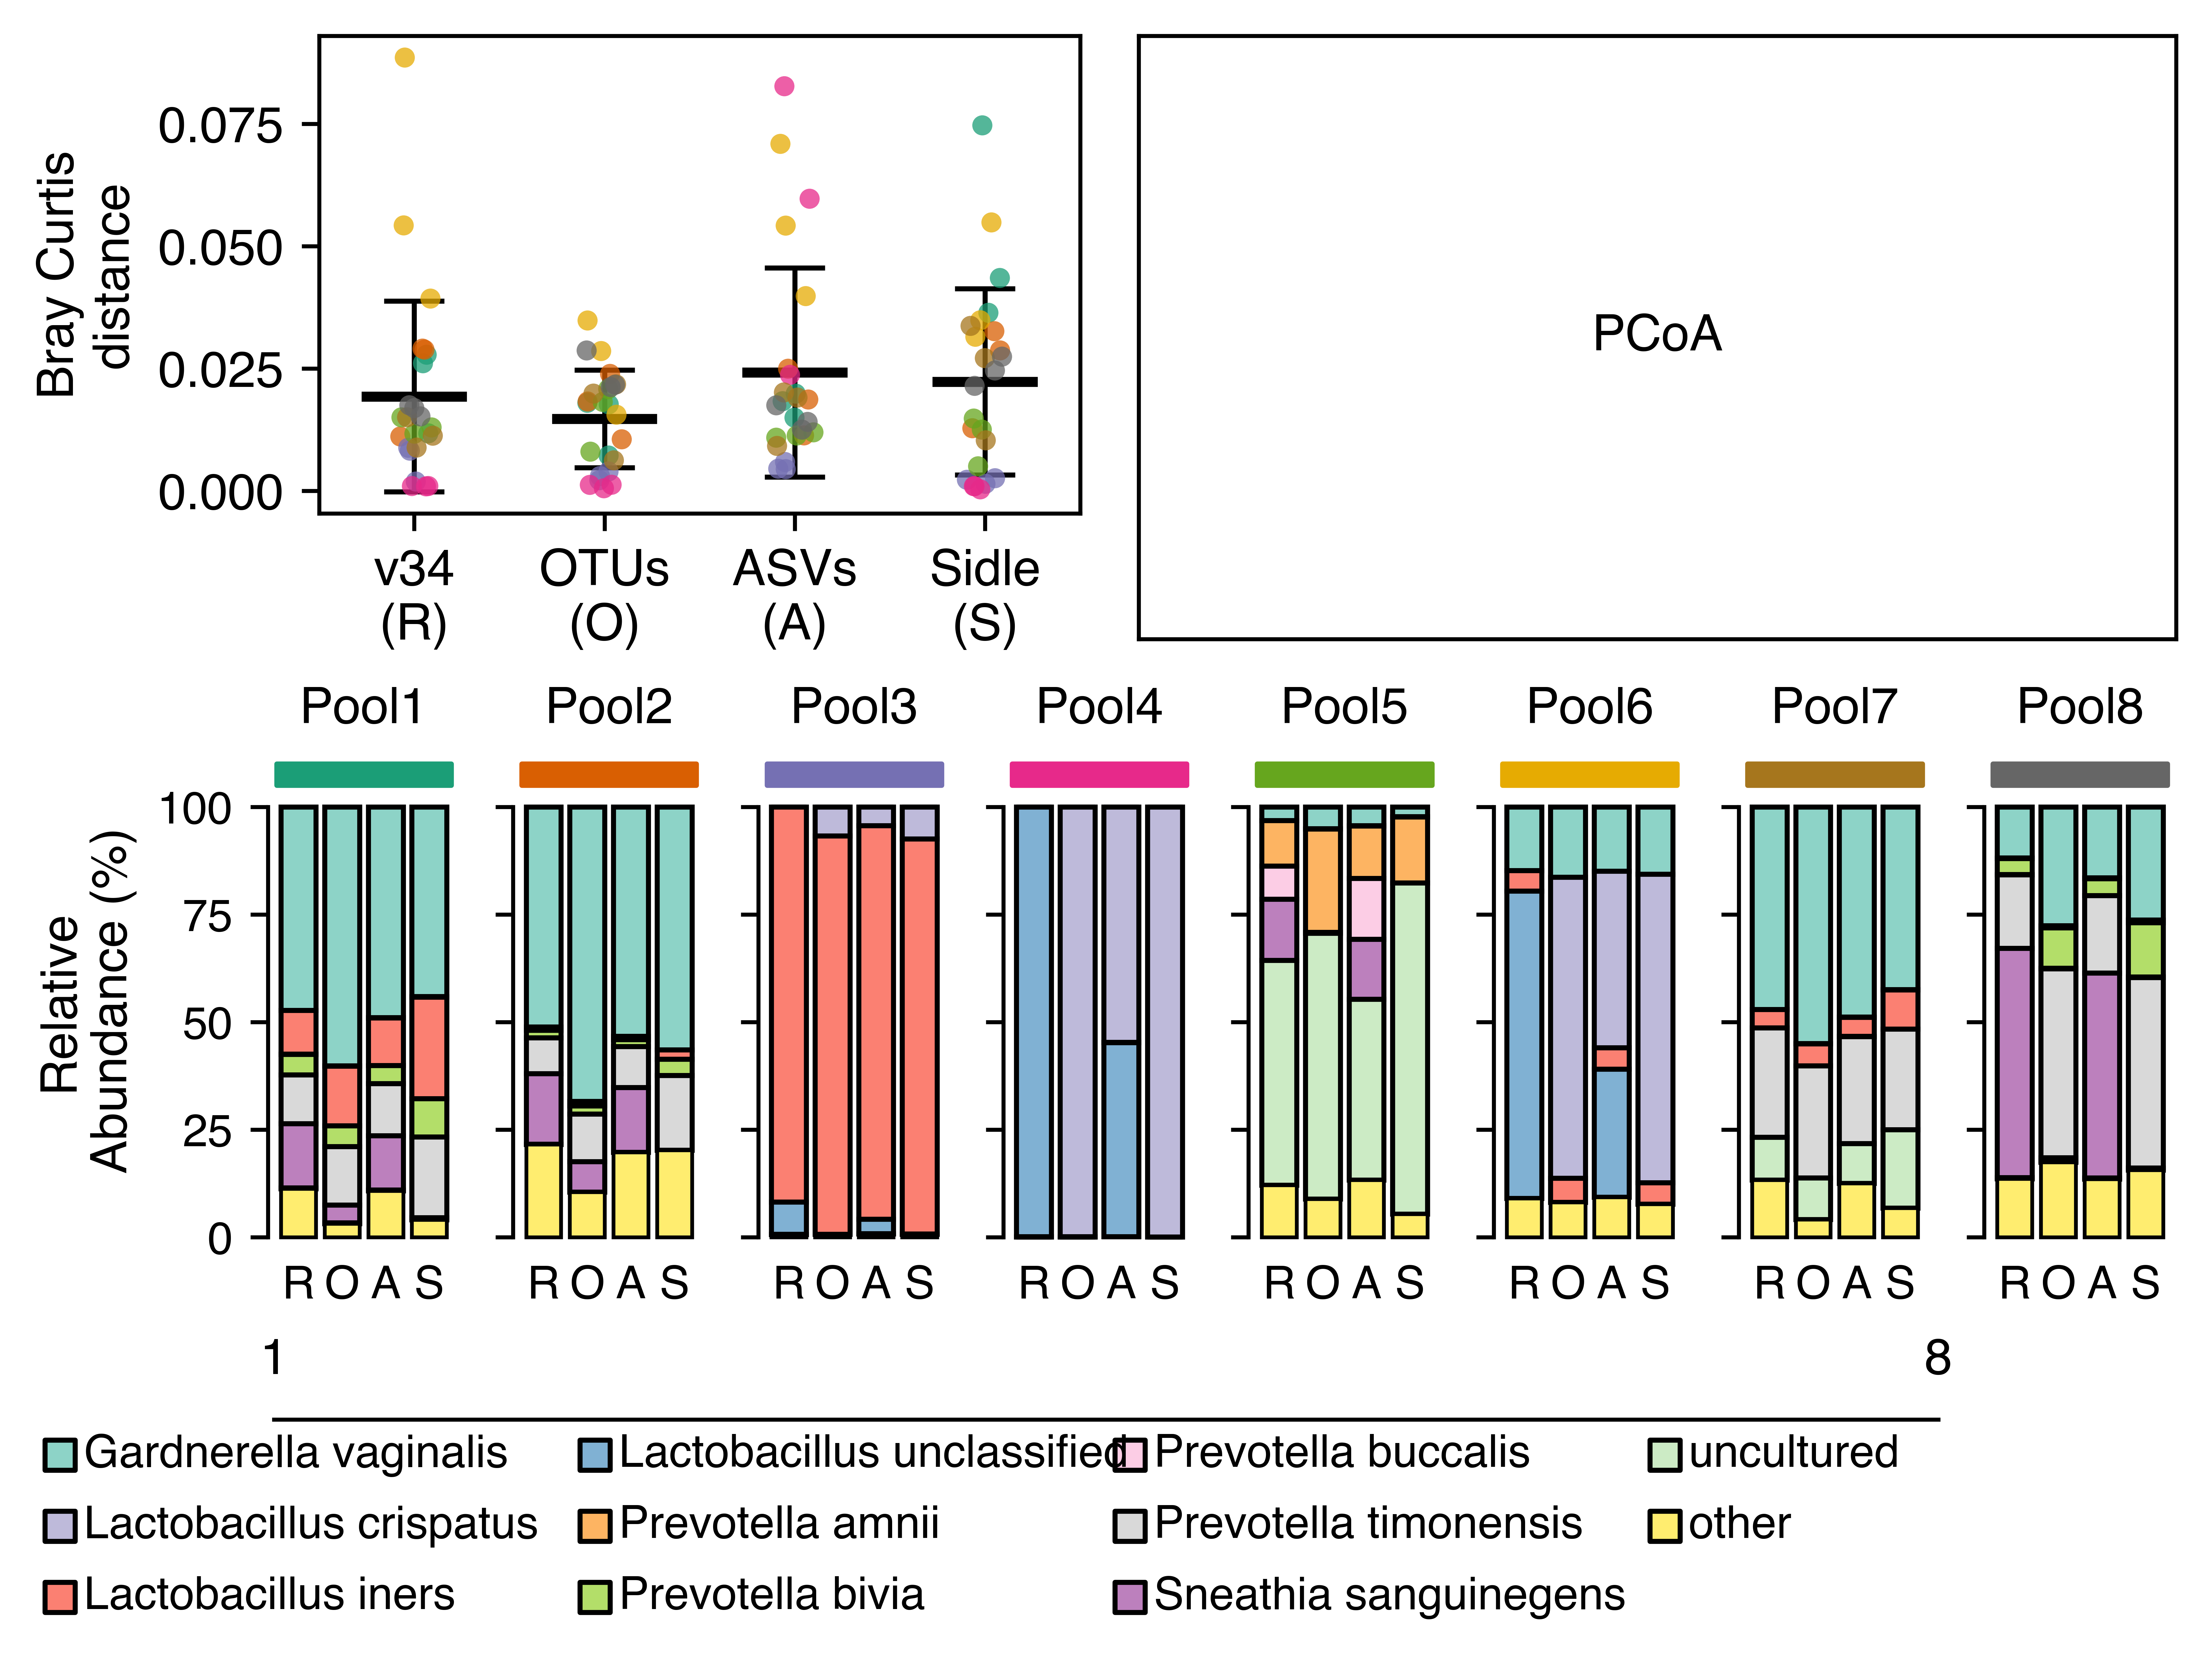

In [49]:
fig_ = plt.figure(constrained_layout=True,
                  dpi=1200,
                  facecolor='None',
                  figsize=(6, 4.5)
                  )
gs = fig_.add_gridspec(5, 4)
ax0 = fig_.add_subplot(gs[0:2, 0:2])
ax0.errorbar(
    x=np.arange(0, 4),
    y=within_dist.groupby('method')['distance'].mean()[methods],
    yerr=(within_dist.groupby('method')['distance'].std())[methods],
    color='k',
    linestyle='',
    capsize=6,
    elinewidth=1,
)
ax0.plot(
    np.vstack([np.arange(0, 4) - 0.25, np.arange(0, 4) + 0.25]),
    np.vstack([within_dist.groupby('method')['distance'].mean()[methods]] * 2),
    color='k',
    linewidth=2,
)
sn.stripplot(
    x='method',
    y='distance',
    hue='pool0',
    data=within_dist,
    palette='Dark2',
    alpha=0.75,
    ax=ax0,
    size=4,
    edgecolor='None',
)
ax0.set_xticklabels(['v34\n(R)', 'OTUs\n(O)',  'ASVs\n(A)', 'Sidle\n(S)',])
ax0.legend_.set_visible(False)
ax0.set_ylabel('Bray Curtis\ndistance')
ax0.set_xlabel('')

gs1 = gs[0:2, 2:].subgridspec(1, 1)
ax1 = fig_.add_subplot(gs1[:, :])
ax1.text(0.5, 0.5, 'PCoA', ha='center', va='center')
ax1.set_xticks([])
ax1.set_yticks([])

gs2 = gs[2:4, :].subgridspec(1, 8, wspace=0, hspace=0)


for i, (pool, pool_color) in enumerate(zip(*(pools, sn.color_palette('Dark2', 8)))):
    ax = fig_.add_subplot(gs2[i])
    for color, taxa in zip(*(colors, abundant_full2.columns)):
        ax.bar(np.arange(0, 4),
               bottom=abundant_full2.loc[pool].cumsum(axis=1).loc[methods, taxa],
               height=-abundant_full2.loc[pool].loc[methods, taxa],
               color=color,
               edgecolor='k',
               label=taxa[-1],
              )
    ax.bar(np.arange(0, 4),
           bottom=abundant_full2.loc[pool].loc[methods].sum(axis=1),
           height=1-abundant_full2.loc[pool].loc[methods].sum(axis=1),
           color=colors[-1],
           edgecolor='k',
           linewidth=0.75,
           label='other',
          )
    ax.fill_between([-0.5, 3.5], [-0.05, -0.05], [-0.1, -0.1], color=pool_color)
    ax.set_yticks(np.arange(0, 1.1, 0.25))
    ax.set_ylim([1.025, -0.125])
    ax.set_yticklabels(np.arange(100, -1, -25))
    ax.set_xticks(np.arange(0, 4))
    ax.set_xticklabels(['R', 'O', 'A', 'S'], size=9)
    ax.yaxis.set_tick_params(labelleft=(i==0), labelsize=9)
    ax.xaxis.set_tick_params(bottom=False, length=0)
    if i == 0:
        ax.set_ylabel('Relative\nAbundance (%)')
        
    ax.set_title(pool.replace('pool', 'Subject'), size=10)
    sn.despine(ax=ax, right=True, top=True, trim=True, bottom=True)
    
gs3 = gs[-1, :].subgridspec(1, 1)
ax_l = fig_.add_subplot(gs3[:, :])
ax_l.set_xlim([0, 9])
ax_l.set_ylim([-0.5, 5.5])
ax_l.scatter(
    x=np.hstack([np.array([i*2.25 + 0.1] * 3) for i in np.arange(0, 4)])[:11],
    y=np.hstack([np.arange(2, -1, -1)*2 + 0.5] * 4)[:11],
    marker='s',
    c=colors,
    edgecolor='k',
#     l=0.5,
)
labels = np.reshape(
    np.hstack([abundant_full.index.values, ['s__other', '__']]),
    (4, 3)
)
for i, label_s in enumerate(labels):
    for j, l in enumerate(label_s):
        ax_l.text(
            x=i*2.25+0.2,
            y=(2-j)*2 + 0.5,
            s=l.split("__")[1].replace('_', ' '),
            ha='left',
            va='center',
            size=9
            )

ax_l.set_xticks([1, 8])
ax_l.set_yticks([])
ax_l.xaxis.set_tick_params(labelbottom=False, top=False, bottom=False, labeltop=False)
sn.despine(ax=ax_l, bottom=True, right=True, left=True, top=False, trim=True)


fig_.savefig('data/output/figures/figure3/figure2_vaginal.png')
fig_.savefig('data/output/figures/figure3/figure2_vaginal.pdf')